In [8]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
import jax

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from functools import partial
from warnings import filterwarnings

from flax import linen as nn
from flax.linen.initializers import ones
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

import blackjax

filterwarnings("ignore")
import matplotlib as mpl

cmap = mpl.colormaps["coolwarm"]

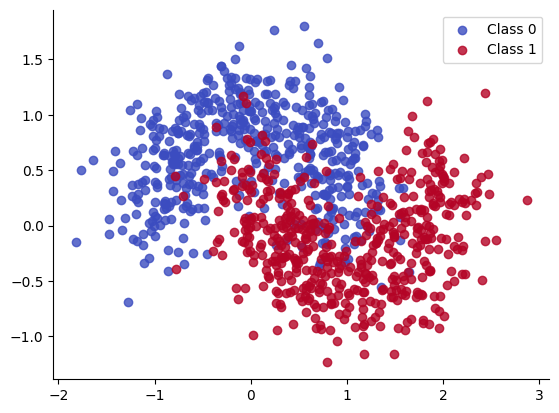

In [9]:
X, Y = make_moons(noise=0.3, n_samples=1000)
for i in range(2):
    plt.scatter(X[Y == i, 0], X[Y == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)
plt.legend();

In [10]:
n_groups = 18
n_samples = 100
n_grps_sq = int(np.sqrt(n_groups))

def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [11]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [12]:
Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

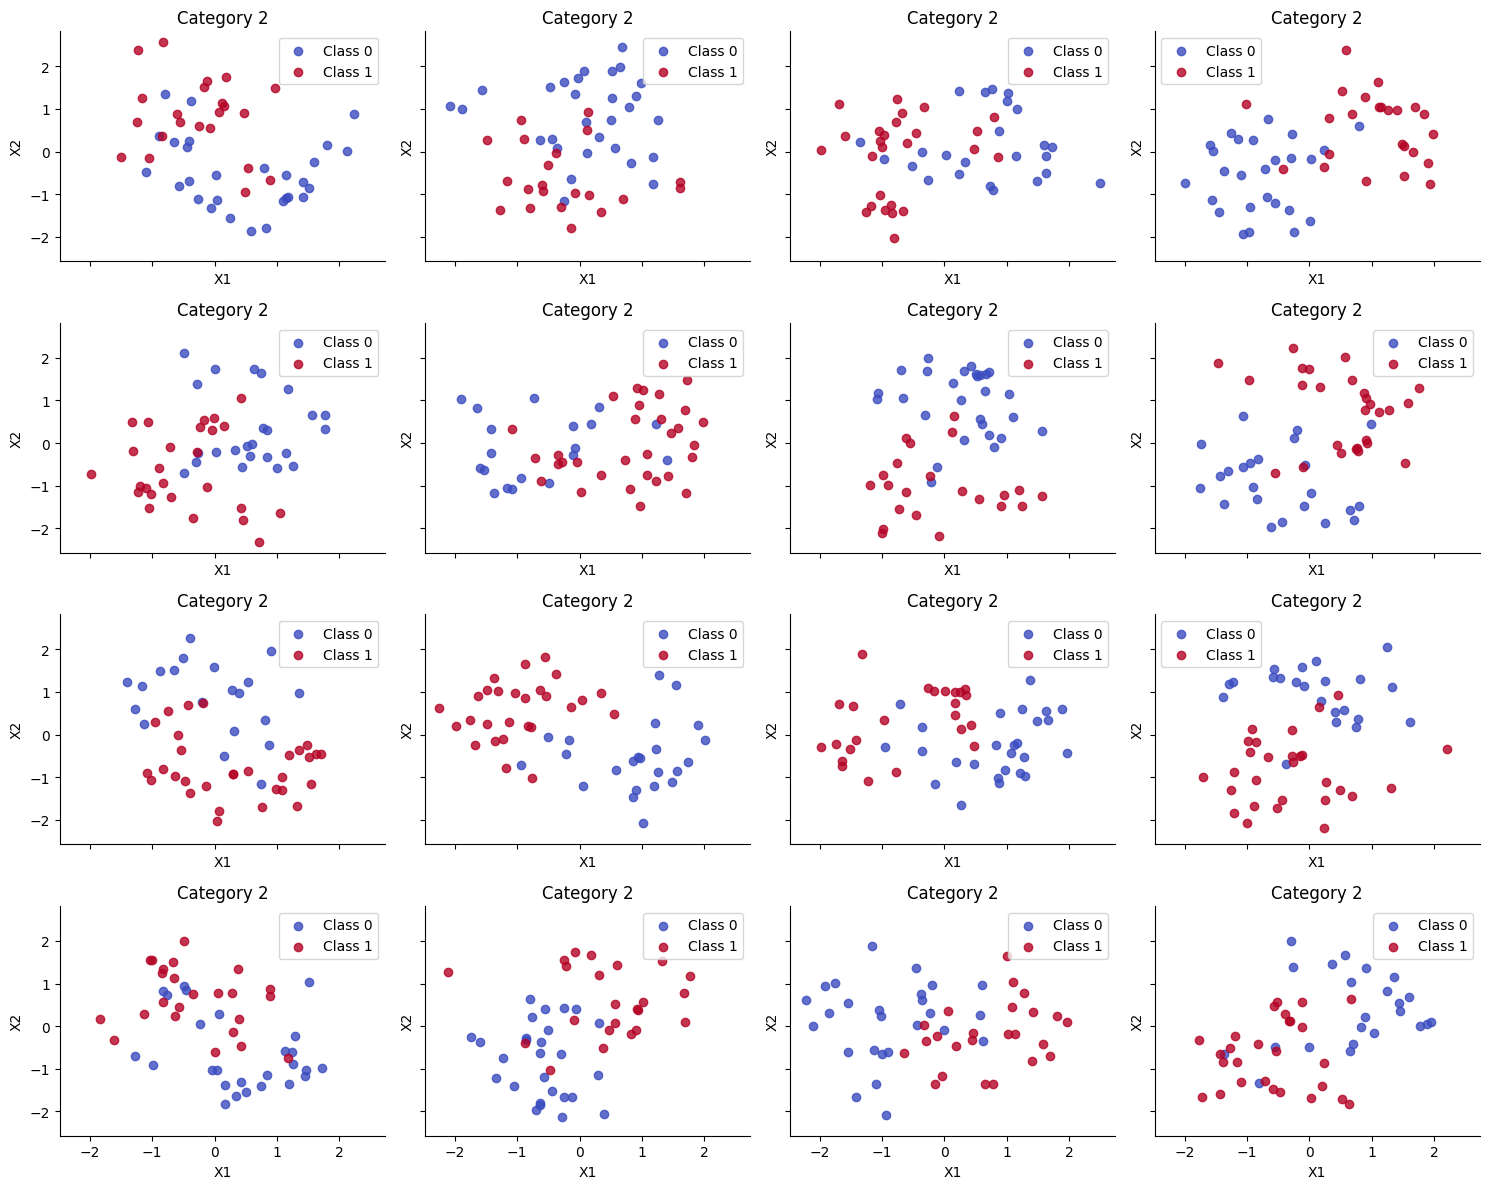

In [13]:
fig, axs = plt.subplots(
    figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True
)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    for i in range(2):
        ax.scatter(X[Y == i, 0], X[Y == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)

    ax.legend()
    ax.set(title=f"Category {i + 1}", xlabel="X1", ylabel="X2")


grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)
plt.tight_layout();

In [14]:
def inference_loop(rng_key, step_fn, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = step_fn(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [15]:
def get_predictions(model, samples, X, rng_key):
    vectorized_apply = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    z = vectorized_apply(samples, X)
    predictions = tfd.Bernoulli(logits=z).sample(seed=rng_key)

    return predictions.squeeze(-1)

In [16]:
def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

In [17]:
def fit_and_eval(
    rng_key,
    model,
    logdensity_fn,
    X_train,
    Y_train,
    X_test,
    grid,
    n_groups=None,
    num_warmup=1000,
    num_samples=500,
):
    (
        init_key,
        warmup_key,
        inference_key,
        train_key,
        test_key,
        grid_key,
    ) = jax.random.split(rng_key, 6)

    if n_groups is None:
        initial_position = model.init(init_key, jnp.ones(X_train.shape[-1]))
    else:
        initial_position = model.init(init_key, jnp.ones(X_train.shape))

    # initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model)

    # warm up
    adapt = blackjax.window_adaptation(blackjax.nuts, logprob)
    (final_state, params), _ = adapt.run(warmup_key, initial_position, num_warmup)
    step_fn = blackjax.nuts(logprob, **params).step

    # inference
    states = inference_loop(inference_key, step_fn, final_state, num_samples)
    samples = states.position

    # evaluation
    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

# MLP

In [18]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [19]:
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(tfd.Normal(0, 1).log_prob(flat_params))


def loglikelihood_fn(params, X, Y, model):
    print("------------------------New try-----------------------------------")
    print("type:")
    print(type(params))
    print("params:")
    print(params)
    logits = jnp.ravel(model.apply(params, X))
    return jnp.sum(tfd.Bernoulli(logits).log_prob(Y))


def logdensity_fn_of_bnn(params, X, Y, model):
    return logprior_fn(params) + loglikelihood_fn(params, X, Y, model)

In [20]:
rng_key, eval_key = jax.random.split(rng_key)
keys = jax.random.split(eval_key, n_groups)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None
    )


Ys_pred_train, Ys_pred_test, ppc_grid_single = jax.vmap(fit_and_eval_single_mlp)(
    keys, Xs_train, Ys_train, Xs_test
)

------------------------New try-----------------------------------
type:
<class 'dict'>
params:
{'params': {'Dense_0': {'bias': Traced<ConcreteArray([0. 0. 0. 0. 0.], dtype=float32)>with<JVPTrace(level=3/0)> with
  primal = Array([0., 0., 0., 0., 0.], dtype=float32)
  tangent = Traced<ShapedArray(float32[5])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[5]), None)
    recipe = LambdaBinding(), 'kernel': Traced<ShapedArray(float32[2,5])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[2,5])>with<BatchTrace(level=1/0)> with
    val = Array([[[-1.2447963 , -0.2833706 , -0.2869921 ,  0.5518258 ,
          0.17649594],
        [ 0.86010647, -0.33939093,  1.2186879 ,  0.14955698,
          0.281287  ]],

       [[ 0.23027383, -0.9761334 , -0.00748283, -0.09109747,
          0.8426485 ],
        [-0.19030347,  0.55610615, -0.02782848,  0.13862608,
         -1.4517933 ]],

       [[-0.14916858, -1.3550719 ,  0.29751617, -0.4283342 ,
          0.59015185],

In [21]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 86.78%


In [22]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 82.22%


In [23]:
def plot_decision_surfaces_non_hierarchical(nrows=2, ncols=2):
    fig, axes = plt.subplots(
        figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True
    )
    axes = axes.flatten()
    for i, (X, Y_pred, Y_true, ax) in enumerate(
        zip(Xs_train, Ys_pred_train, Ys_train, axes)
    ):
        ax.contourf(
            grid[:, 0].reshape(100, 100),
            grid[:, 1].reshape(100, 100),
            ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100),
            cmap=cmap,
        )
        for i in range(2):
            ax.scatter(
                X[Y_true == i, 0], X[Y_true == i, 1], 
                color=cmap(float(i)), label=f"Class {i}", alpha=.8)
        ax.legend()

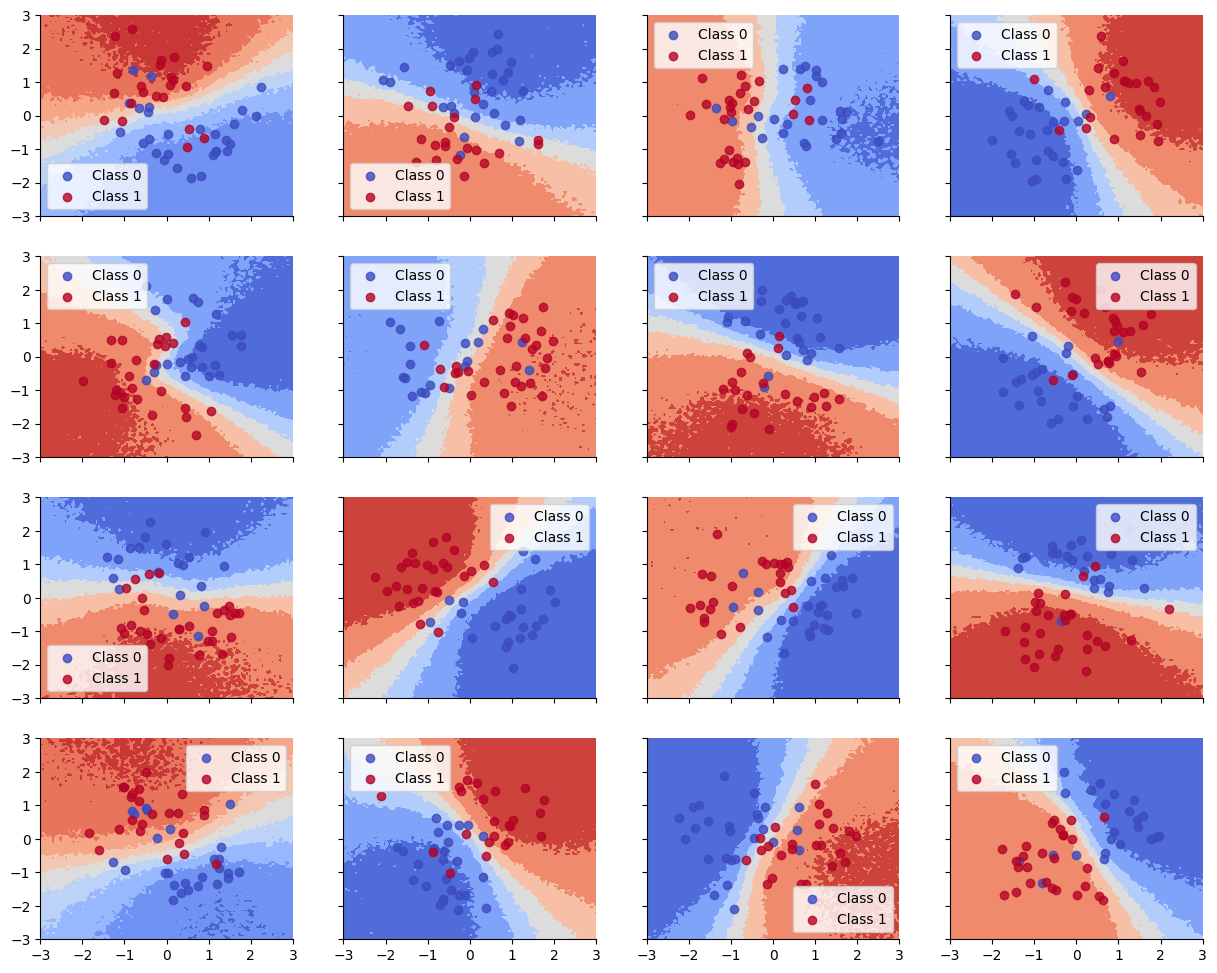

In [24]:
plot_decision_surfaces_non_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)